# Costumizar o Ambiente Taxi do OpenAI Gymnasium e Implementação de Agentes de Reinforcement Learning Através da Biblioteca Stable Baselines

O objetivo deste trabalho é o desenvolvimento de agentes de reinforcement learning utilizando um ambiente do OpenAI Gymnasium como base. Neste trabalho vamos introduzir alterações ao ambiente e treinar um agente recorrendo à biblioteca Stable Baselines 3, analisando no fim como é que as alterações afetam o desempenho do agente.

## Ambiente escolhido - Taxi
[Link do ambiente escolhido](https://www.gymlibrary.dev/environments/toy_text/taxi/)

Este ambiente corresponde ao Taxi Problem do “Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition”, de Tom Dietterich.
![Alt Text](https://www.gymlibrary.dev/_images/taxi.gif)
### Descrição
Existem 4 localizações específicas designadas por R(ed), G(reen), Y(ellow), e B(lue). Quando o episódio começa, o taxi começa numa posição aleatória e o passageiro numas das 4 localizações referidas acima. O taxi conduz até à localização do passageiro, "apanha" o passageiro e leva-o ao seu destino, que é uma das outras 4 localizações diferente da posição inicial do passageiro, e "larga"-o lá. Quando o passageiro estiver na posição de destino e fora do taxi, o episódio acaba.

### Ações
> action_space = Discrete(6)

Existem 6 ações possíveis:
- 0: mover para Sul
- 1: mover para Norte
- 2: mover para Este
- 3: mover para Oeste
- 4: apanhar o passageiro
- 5: largar o passageiro

### Observações
> observations_space = Discrete(500)

Existem 500 estados possíveis pois há 25 posições para o taxi, 5 localizações possíveis para o passageiro (incluindo quando ele está dentro do taxi) e 4 posições de destino.

### Recompensas
- -1 por cada passo onde não recebe recompensa positiva
- +20 por entregar o passageiro
- -10 executar ações de apanhar e largar passageiro ilegalmente (quando não está na mesma posição que o passageiro)

## Modelos escolhidos
- [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html)
- [Maskable PPO](https://sb3-contrib.readthedocs.io/en/master/modules/ppo_mask.html)
- [ARS](https://sb3-contrib.readthedocs.io/en/master/modules/ars.html)

De todos os modelos que podiamos ter escolhido, escolhemos o modelo Maskable PPO por ter os melhores resultados sem qualquer alteração ao ambiente, como vamos mostrar mais à frente, para realizarmos o treino de hiperparametros. Escolhemos os outros dois por terem resultados negativos com o ambiente default e queriamos analisar se as alterações que iremos efetuar no ambiente resulta em alguma alteração positiva nestes modelos.

## Código para os modelos
### A2C

In [ ]:
import comet_ml
comet_ml.init(project_name="comet-examples-gymnasium-notebook")

from comet_ml.integration.gymnasium import CometLogger
from stable_baselines3 import A2C
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode = "rgb_array")

# Uncomment if you want to Upload Videos of your environment to Comet
#env = gym.wrappers.RecordVideo(env, 'test')

experiment = comet_ml.Experiment()

env = CometLogger(env, experiment)

model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=1_000_000,  progress_bar=True)
model.save()

env.close()
experiment.end()


### Maskable PPO

In [ ]:
import comet_ml
comet_ml.init(project_name="comet-examples-gymnasium-notebook")
import gymnasium as gym
import numpy as np

from comet_ml.integration.gymnasium import CometLogger
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO


def mask_fn(env):
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.unwrapped.action_mask(env.unwrapped.s)


env = gym.make("Taxi-v3")


#env = gym.wrappers.RecordVideo(env, 'test')

env = ActionMasker(env, mask_fn)  # Wrap to enable masking


experiment = comet_ml.Experiment()

env = CometLogger(env, experiment)

# MaskablePPO behaves the same as SB3's PPO unless the env is wrapped
# with ActionMasker. If the wrapper is detected, the masks are automatically
# retrieved and used when learning. Note that MaskablePPO does not accept
# a new action_mask_fn kwarg, as it did in an earlier draft.
model = MaskablePPO(MaskableActorCriticPolicy, env, verbose=0)
model.learn(total_timesteps=5_000_000, progress_bar=True)
model.save("maskppo")

env.close()
experiment.end()

### ARS

In [ ]:
import comet_ml
comet_ml.init(project_name="comet-examples-gymnasium-notebook")
from comet_ml.integration.gymnasium import CometLogger
from sb3_contrib import ARS
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode = "rgb_array")

# Uncomment if you want to Upload Videos of your environment to Comet
#env = gym.wrappers.RecordVideo(env, 'test')

experiment = comet_ml.Experiment()

env = CometLogger(env, experiment)

model = ARS("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=1_000_000,  progress_bar=True)
model.save('ARS')
env.close()
experiment.end()

## Resultado dos Modelos sem alterações am ambiente
### ARS
![Imagem WhatsApp 2023-12-15 às 14.01.25_9e8ea684.jpg](<attachment:Imagem WhatsApp 2023-12-15 às 14.01.25_9e8ea684.jpg>)
### Maskble PPO
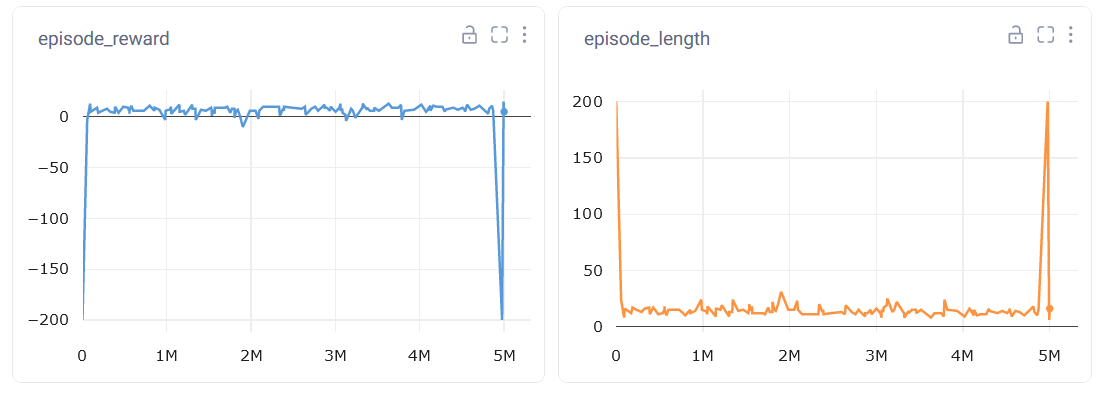
### A2C
![Imagem WhatsApp 2023-12-15 às 14.01.58_0a295fd8.jpg](<attachment:Imagem WhatsApp 2023-12-15 às 14.01.58_0a295fd8.jpg>)

Pela análise dos gráficos, conseguimos entender que os modelos ARS e A2C não conseguem aprender o problema em questão. Por outro lado, o modelo Maskble PPO consegue aprendê-lo facilmente. Isto provavelmente acontece porque este modelo em específico consegue ter acesso a uma action_mask, que corresponde a uma matriz de 0s e 1s representativa das ações que resultam em mudança de estado (por exemplo, [1 0 1 0 0 0] quer dizer que apenas as ações 0 e 2 resultam em mudança de estado e devem ser apenas estas a ser consideradas pelo modelo).
O proxímo passo no nosso trabalho será introduzir uma alteração ao ambiente com o objetivo de tornar a action_mask disponível ao nível do ambiente em si e não apenas de um modelo construído com o objetivo de aceder à action_mask.

## Alterações ao Ambiente
Para conseguirmos introduzir as alterações, criámos um ambiente customizado que é uma cópia do ambiente ["Taxi-v3"](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/taxi.py)(source code) com a seguinte alteração:
A variável que representa o action_space é da classe CustomDiscrete (ver código abaixo), que tem como base a classe [Discrete](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/spaces/discrete.py)(source code) do gymnasium.
Esta variável vai ter acesso ao próprio ambiente e quando é chamada a função env.action_space.sample(), a função tem em conta apenas as ações possíves com base na action_mask do ambiente.

### Código da Class CustomDiscrete
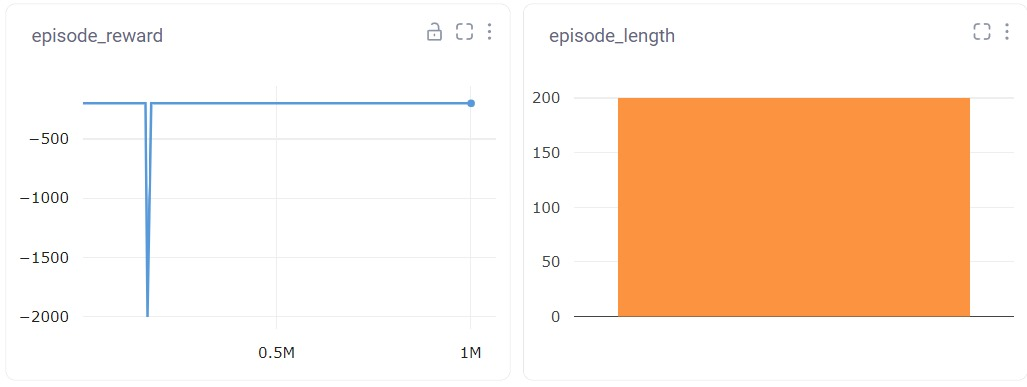
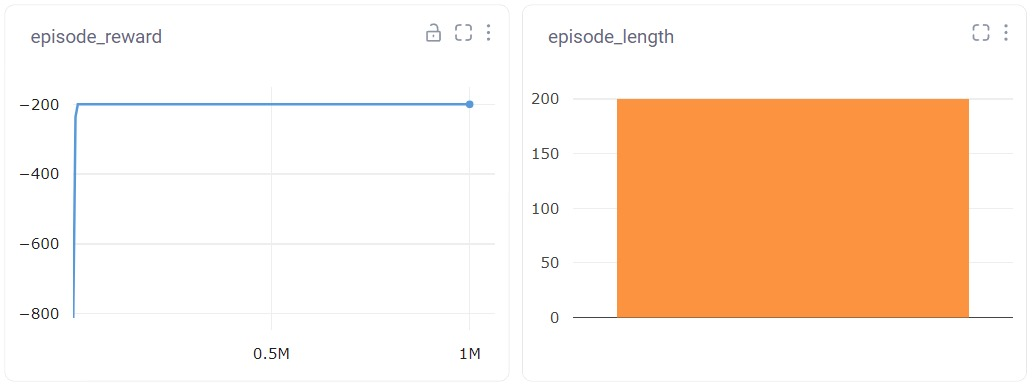

In [ ]:
"""Implementation of a space consisting of finitely many elements."""
from __future__ import annotations

from typing import Any, Iterable, Mapping, Sequence

import numpy as np

from gymnasium.spaces.space import MaskNDArray, Space
from gymnasium import spaces


class CustomDiscrete(Space[np.int64]):
    r"""A space consisting of finitely many elements.

    This class represents a finite subset of integers, more specifically a set of the form :math:`\{ a, a+1, \dots, a+n-1 \}`.

    Example:
        >>> from gymnasium.spaces import Discrete
        >>> observation_space = Discrete(2, seed=42) # {0, 1}
        >>> observation_space.sample()
        0
        >>> observation_space = Discrete(3, start=-1, seed=42)  # {-1, 0, 1}
        >>> observation_space.sample()
        -1
    """

    def __init__(
        self,
        n: int | np.integer[Any],
        env,
        seed: int | np.random.Generator | None = None,
        start: int | np.integer[Any] = 0,
    ):
        r"""Constructor of :class:`Discrete` space.

        This will construct the space :math:`\{\text{start}, ..., \text{start} + n - 1\}`.

        Args:
            n (int): The number of elements of this space.
            seed: Optionally, you can use this argument to seed the RNG that is used to sample from the ``Dict`` space.
            start (int): The smallest element of this space.
        """
        assert np.issubdtype(
            type(n), np.integer
        ), f"Expects `n` to be an integer, actual dtype: {type(n)}"
        assert n > 0, "n (counts) have to be positive"
        assert np.issubdtype(
            type(start), np.integer
        ), f"Expects `start` to be an integer, actual type: {type(start)}"

        self.n = np.int64(n)
        self.env = env
        self.start = np.int64(start)
        super().__init__((), np.int64, seed)
        self.__class__ = spaces.Discrete

    @property
    def is_np_flattenable(self):
        """Checks whether this space can be flattened to a :class:`spaces.Box`."""
        return True

    def sample(self, mask: MaskNDArray | None = None) -> np.int64:
        """Generates a single random sample from this space.

        A sample will be chosen uniformly at random with the mask if provided

        Args:
            mask: An optional mask for if an action can be selected.
                Expected `np.ndarray` of shape ``(n,)`` and dtype ``np.int8`` where ``1`` represents valid actions and ``0`` invalid / infeasible actions.
                If there are no possible actions (i.e. ``np.all(mask == 0)``) then ``space.start`` will be returned.

        Returns:
            A sampled integer from the space
        """

        mask = self.env.action_mask(self.env.s)
        print(f"Custom Sample Mask Function called with mask= {mask}")
        if mask is not None:
            assert isinstance(
                mask, np.ndarray
            ), f"The expected type of the mask is np.ndarray, actual type: {type(mask)}"
            assert (
                mask.dtype == np.int8
            ), f"The expected dtype of the mask is np.int8, actual dtype: {mask.dtype}"
            assert mask.shape == (
                self.n,
            ), f"The expected shape of the mask is {(self.n,)}, actual shape: {mask.shape}"
            valid_action_mask = mask == 1
            assert np.all(
                np.logical_or(mask == 0, valid_action_mask)
            ), f"All values of a mask should be 0 or 1, actual values: {mask}"
            if np.any(valid_action_mask):
                return self.start + self.np_random.choice(
                    np.where(valid_action_mask)[0]
                )
            else:
                return self.start

        return self.start + self.np_random.integers(self.n)

    def contains(self, x: Any) -> bool:
        """Return boolean specifying if x is a valid member of this space."""
        if isinstance(x, int):
            as_int64 = np.int64(x)
        elif isinstance(x, (np.generic, np.ndarray)) and (
            np.issubdtype(x.dtype, np.integer) and x.shape == ()
        ):
            as_int64 = np.int64(x)
        else:
            return False

        return bool(self.start <= as_int64 < self.start + self.n)

    def __repr__(self) -> str:
        """Gives a string representation of this space."""
        if self.start != 0:
            return f"CustomDiscrete({self.n}, start={self.start})"
        return f"CustomDiscrete({self.n})"

    def __eq__(self, other: Any) -> bool:
        """Check whether ``other`` is equivalent to this instance."""
        return (
            isinstance(other, Discrete)
            and self.n == other.n
            and self.start == other.start
        )

    def __setstate__(self, state: Iterable[tuple[str, Any]] | Mapping[str, Any]):
        """Used when loading a pickled space.

        This method has to be implemented explicitly to allow for loading of legacy states.

        Args:
            state: The new state
        """
        # Don't mutate the original state
        state = dict(state)

        # Allow for loading of legacy states.
        # See https://github.com/openai/gym/pull/2470
        if "start" not in state:
            state["start"] = np.int64(0)

        super().__setstate__(state)

    def to_jsonable(self, sample_n: Sequence[np.int64]) -> list[int]:
        """Converts a list of samples to a list of ints."""
        return [int(x) for x in sample_n]

    def from_jsonable(self, sample_n: list[int]) -> list[np.int64]:
        """Converts a list of json samples to a list of np.int64."""
        return [np.int64(x) for x in sample_n]

### Código do ambiente costumizado TaxiEnvMask

In [ ]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

import numpy as np

import gymnasium as gym
from gymnasium import Env, spaces, utils
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.error import DependencyNotInstalled


MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)


class TaxiEnvMask(Env):
    """
    The Taxi Problem involves navigating to passengers in a grid world, picking them up and dropping them
    off at one of four locations.

    ## Description
    There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the
    5x5 grid world. The taxi starts off at a random square and the passenger at one of the
    designated locations.

    The goal is move the taxi to the passenger's location, pick up the passenger,
    move to the passenger's desired destination, and
    drop off the passenger. Once the passenger is dropped off, the episode ends.

    The player receives positive rewards for successfully dropping-off the passenger at the correct
    location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and
    for each step where another reward is not received.

    Map:

            +---------+
            |R: | : :G|
            | : | : : |
            | : : : : |
            | | : | : |
            |Y| : |B: |
            +---------+

    From "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich [<a href="#taxi_ref">1</a>].

    ## Action Space
    The action shape is `(1,)` in the range `{0, 5}` indicating
    which direction to move the taxi or to pickup/drop off passengers.

    - 0: Move south (down)
    - 1: Move north (up)
    - 2: Move east (right)
    - 3: Move west (left)
    - 4: Pickup passenger
    - 5: Drop off passenger

    ## Observation Space
    There are 500 discrete states since there are 25 taxi positions, 5 possible
    locations of the passenger (including the case when the passenger is in the
    taxi), and 4 destination locations.

    Destination on the map are represented with the first letter of the color.

    Passenger locations:
    - 0: Red
    - 1: Green
    - 2: Yellow
    - 3: Blue
    - 4: In taxi

    Destinations:
    - 0: Red
    - 1: Green
    - 2: Yellow
    - 3: Blue

    An observation is returned as an `int()` that encodes the corresponding state, calculated by
    `((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination`

    Note that there are 400 states that can actually be reached during an
    episode. The missing states correspond to situations in which the passenger
    is at the same location as their destination, as this typically signals the
    end of an episode. Four additional states can be observed right after a
    successful episodes, when both the passenger and the taxi are at the destination.
    This gives a total of 404 reachable discrete states.

    ## Starting State
    The episode starts with the player in a random state.

    ## Rewards
    - -1 per step unless other reward is triggered.
    - +20 delivering passenger.
    - -10  executing "pickup" and "drop-off" actions illegally.

    An action that results a noop, like moving into a wall, will incur the time step
    penalty. Noops can be avoided by sampling the `action_mask` returned in `info`.

    ## Episode End
    The episode ends if the following happens:

    - Termination:
            1. The taxi drops off the passenger.

    - Truncation (when using the time_limit wrapper):
            1. The length of the episode is 200.

    ## Information

    `step()` and `reset()` return a dict with the following keys:
    - p - transition proability for the state.
    - action_mask - if actions will cause a transition to a new state.

    As taxi is not stochastic, the transition probability is always 1.0. Implementing
    a transitional probability in line with the Dietterich paper ('The fickle taxi task')
    is a TODO.

    For some cases, taking an action will have no effect on the state of the episode.
    In v0.25.0, ``info["action_mask"]`` contains a np.ndarray for each of the actions specifying
    if the action will change the state.

    To sample a modifying action, use ``action = env.action_space.sample(info["action_mask"])``
    Or with a Q-value based algorithm ``action = np.argmax(q_values[obs, np.where(info["action_mask"] == 1)[0]])``.


    ## Arguments

    ```python
    import gymnasium as gym
    gym.make('Taxi-v3')
    ```

    ## References
    <a id="taxi_ref"></a>[1] T. G. Dietterich, “Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition,”
    Journal of Artificial Intelligence Research, vol. 13, pp. 227–303, Nov. 2000, doi: 10.1613/jair.639.

    ## Version History
    * v3: Map Correction + Cleaner Domain Description, v0.25.0 action masking added to the reset and step information
    * v2: Disallow Taxi start location = goal location, Update Taxi observations in the rollout, Update Taxi reward threshold.
    * v1: Remove (3,2) from locs, add passidx<4 check
    * v0: Initial version release
    """

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        self.P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            terminated = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if pass_idx < 4 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    terminated = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            self.P[state][action].append(
                                (1.0, new_state, reward, terminated)
                            )
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = {}
        self.observation_space = spaces.Discrete(num_states)

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.taxi_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

    def set_action_space(self, action_s):
      self.action_space = action_s

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def action_mask(self, state: int):
        """Computes an action mask for the action space using the state information."""
        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        if taxi_row < 4:
            mask[0] = 1
        if taxi_row > 0:
            mask[1] = 1
        if taxi_col < 4 and self.desc[taxi_row + 1, 2 * taxi_col + 2] == b":":
            mask[2] = 1
        if taxi_col > 0 and self.desc[taxi_row + 1, 2 * taxi_col] == b":":
            mask[3] = 1
        if pass_loc < 4 and (taxi_row, taxi_col) == self.locs[pass_loc]:
            mask[4] = 1
        if pass_loc == 4 and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1
        return mask

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return
        elif self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame  # dependency to pygame only if rendering with human
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[toy-text]`"
            ) from e

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert (
            self.window is not None
        ), "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.taxi_imgs is None:
            file_names = [
                path.join(path.dirname(__file__), "img/cab_front.png"),
                path.join(path.dirname(__file__), "img/cab_rear.png"),
                path.join(path.dirname(__file__), "img/cab_right.png"),
                path.join(path.dirname(__file__), "img/cab_left.png"),
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = path.join(path.dirname(__file__), "img/passenger.png")
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = path.join(path.dirname(__file__), "img/hotel.png")
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                path.join(path.dirname(__file__), "img/gridworld_median_left.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_horiz.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_right.png"),
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                path.join(path.dirname(__file__), "img/gridworld_median_top.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_vert.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_bottom.png"),
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = path.join(path.dirname(__file__), "img/taxi_background.png")
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        if pass_idx < 4:
            self.window.blit(self.passenger_img, self.get_surf_loc(self.locs[pass_idx]))

        if self.lastaction in [0, 1, 2, 3]:
            self.taxi_orientation = self.lastaction
        dest_loc = self.get_surf_loc(self.locs[dest_idx])
        taxi_location = self.get_surf_loc((taxi_row, taxi_col))

        if dest_loc[1] <= taxi_location[1]:
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
        else:  # change blit order for overlapping appearance
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )

        if mode == "human":
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

    def _render_text(self):
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        out = [[c.decode("utf-8") for c in line] for line in desc]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


## Resultados após a alteração implementada

Através da alteração que implementámos no nosso ambiente, concluimos que o fator que mais afeta os resultados é o facto de o agente conseguir evitar ou não que o taxi se desloque para posições inválidas. 

Este vídeo representa o modelo a agir sobre o ambiente após o treino no ambiente alterado:

<video src="V%C3%ADdeo%20WhatsApp%202023-12-15%20%C3%A0s%2013.23.30_4208ad76.mp4" controls title="Title"></video>


## Hiperparâmetros
Como o modelo Maskable PPO já tinha resultados bastantes bons com o ambiente default, decidimos utlizar este modelo para realizar o treino de hiperparametros. Testamos com este set de hiperparametros:
- learning rate : [0.001, 0.0001, 0.00001]
- Coenficente de entropia : [0.01, 0.001, 0.0001]

Resultando do treino, estes foram os hiperparametros escolhidos:

In [ ]:
import gymnasium as gym

from comet_ml.integration.gymnasium import CometLogger
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO


def mask_fn(env):
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.unwrapped.action_mask(env.unwrapped.s)


env = gym.make("Taxi-v3")


#env = gym.wrappers.RecordVideo(env, 'test')

env = ActionMasker(env, mask_fn)  # Wrap to enable masking

experiment = comet_ml.Experiment()

env = CometLogger(env, experiment)

model = MaskablePPO(MaskableActorCriticPolicy, env, learning_rate=0.001, ent_coef=0.0001, verbose=0)
model.learn(total_timesteps=1_000_000, progress_bar=True)
model.save("maskppo_taxi_5M_HP")

env.close()
experiment.end()

## Conclusão
Mais do que com os hiperpârametros, quando adicionamos o acesso à action_mask para corrigir o problema supramencionado todos os algoritmos mostraram ser capazes de aprender. Com isto, conseguimos perceber a alteração chave necessária de aplicar ao ambiente para conseguirmos obter resultados positivos com modelos de reinforcement learning da biblioteca Stable Baselines 3 